In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import PySCFPeriodicDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis, lowdin_orthogonalize
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
              }, 
    
}

# Dataset

In [121]:
# workdir = './'
workdir = '/home/pegolo/Software/mlelec/examples/data/periodic/c2-cp2k-benchmarks'
START = 0 
STOP = 5
SKIP = 10
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root

frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [122]:
# workdir = './'
workdir = '/home/pegolo/Software/mlelec/examples/data/periodic/c2-cp2k-benchmarks'
START = 3
STOP = 8
SKIP = 10
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root
frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]

testset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [76]:
aaa = np.array([rfock0[i][0,0,0][0,0] - rfock[i][0,0,0][0,0] for i in range(174)])
# np.random.shuffle(aaa)

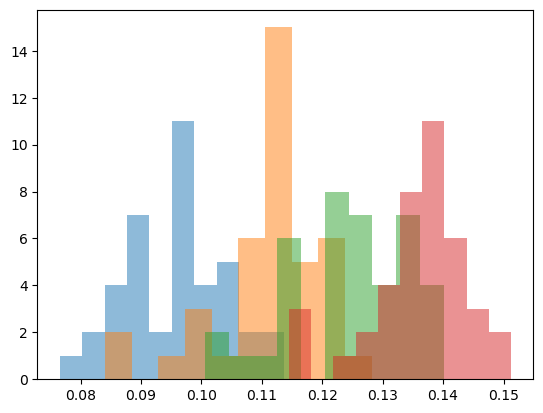

In [77]:
for i in range(174//40):
    plt.hist(aaa[40*i:40*(i+1)], alpha = 0.5)

In [44]:
print(list(range(START, SKIP*STOP, SKIP)))
slice(START, SKIP*STOP, SKIP)

[0, 20, 40, 60, 80]


slice(0, 100, 20)

In [26]:
# for ifr in range(len(rover)):
#     for T in rover[ifr]:
#         print(ifr, T, np.linalg.norm(rover[ifr][T]- rover0[ifr][T]))

In [123]:
cutoff = 8
SORT_ORBS = True
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')


In [124]:
_, test_coupled_blocks = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)

In [125]:
rfock_diff = []
for K, K0 in zip(rfock, rfock0):
    rfock_diff.append({})
    for T in K:
        rfock_diff[-1][T] = K[T] -K0[T]


In [48]:
_, fock0_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0 )


In [49]:
target_blocks_base, target_coupled_blocks_base = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff )

In [50]:
target_kspace = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks, dataset))
target_kspace_base = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks_base, dataset))


# Features 

In [126]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
spline_basis = False

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

hfeat = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features
cpu single center features
cpu single center features


In [127]:
hfeat_test = compute_features(testset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features
cpu single center features
cpu single center features


# Model

In [52]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 32, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

## RIDGE models 

In [117]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

### A - direct H(T)

In [128]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(4.2190e-05)


In [129]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)

/home/pegolo/Software/mlelec/src/mlelec/models/linear.py:757: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [130]:
L2_loss(test_coupled_blocks, pred_test_ridge)

tensor(0.0037)

### B. - baselined H(T)

In [55]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)
pred_ht = mts.add(pred_ridge_bias, fock0_coupled_blocks)
L2_loss(pred_ht, target_coupled_blocks)

tensor(8.6237e-09)


tensor(8.6237e-09)

In [131]:
f=[]
for i in range(7):
    f.append(mts.load(f'features_{i*20}_{(i+1)*20}'))
f.append(mts.load('../test/features_140_172'))
np.random.seed(73)
indices = np.arange(172)
np.random.shuffle(indices)
np.savetxt('random_indices.txt', indices, header = 'seed = 73', fmt = '%d')
batched = {}
for i in range(0,7):
    selid = indices[i*20:20*(i+1)]
    batched[i]=[]
    for iid in selid:
        # batched[i].append(iid)
        batched[i].append(split_features[iid])
batched[8]=[]
selid = indices[140:]
for iid in selid:
    # batched[i].append(iid)
    batched[i].append(split_features[iid])


for i in batched.keys(): 
    features = mts.join(batched[i], axis='samples')
    blocks = []
    for k, b in features.items():
            sample_values = b.samples.values
            sample_values[:, 0] = sample_values[:, 6]
            samples = mts.Labels(b.samples.names[:-1], sample_values[:, :-1])
            blocks.append(mts.TensorBlock(
            values = b.values,
            samples = samples,
            properties = b.properties,
            components = b.components
            ))
    features = mts.TensorMap(features.keys, blocks)
    features.save(f'features_{i*20}_{(i+1)*20}_seed73')

In [134]:
from metatensor.torch import save
save?

Signature:   save(*args, **kwargs)
Type:        OpOverloadPacket
String form: metatensor.save
File:        ~/micromamba/envs/sci/lib/python3.11/site-packages/torch/_ops.py
Docstring:   <no docstring>

### D. -  H(k)

### E. - baselined H(k)

## Torch

In [58]:
split_by_axis = "samples"
split_by_dimension = "structure"

split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(overlap_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
#split_overlaps = mts.split(overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(hfeat, axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(hfeat, split_by_axis, grouped_labels)

ml_data = IndexedDataset(descriptor = split_features,
                         target = split_target,
                         target_k = target_kspace,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

batch_size = 1

from metatensor.learn import DataLoader
dataloader = DataLoader(ml_data,
                        batch_size = batch_size,
                        shuffle = True,
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


Signature:
group_and_join_mts(
    batch: List[NamedTuple],
    fields_to_join: Optional[List[str]] = None,
    join_kwargs: Optional[dict] = None,
) -> <function NamedTuple at 0x7ecca872efc0>
Docstring:
Collates a minibatch by grouping the data for each fields, joining tensors
along the samples axis, and returning a named tuple.

Similar in functionality to the generic :py:func:`group`, but instead data
fields that are :py:class:`torch.Tensor` objects are vertically stacked, and
:py:class:`TensorMap` objects are joined along the samples axis.

`batch` is a list of named tuples. Each has a number of fields that
correspond to different named data fields. These data fields can be
arbitrary objects, such as :py:class:`torch.Tensor`,
:py:class:`atomistic.Systems`, or :py:class:`TensorMap`.

For each data field, the data object from each sample in the batch is
collated into a list, except where the data field is a list of
:py:class:`torch.Tensor` or :py:class:`TensorMap` objects. In this ca